HW1:資料分析
===
數四乙 林祐辰

* 匯入所需套件

In [73]:
import pandas as pd # 載入pandas 套件 命名引用名稱:pd
import numpy as np # 載入numpy 套件 命名引用名稱:np
import matplotlib.pyplot as plt # 載入matplotlib 套件 命名引用名稱:plt
import seaborn as sns # 載入seaborn 套件 命名引用名稱:sns
import plotly.express as px # 載入plotly.expres 套件 命名引用名稱:px

from sklearn.linear_model import LinearRegression # 載入LinearRegression 的函式
from sklearn.model_selection import KFold # 載入KFold 的函式

## 前置處理步驟

* 匯入資料集

In [74]:
rowdata = pd.read_csv('./diabetes.csv')  # 讀入csv檔，並把資料命名為 'rowdata'
rowdata.head(12) # 列出出前12筆資料

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


> 透過列出前12筆資料，讓我們確定已經將資料集正確的讀取。                                                                                         
> 此外，我們能發現Outcome屬於標註資訊，在後續開發模型時不能作為特徵變量。

### 資料集內容分析

* 查看資料型態

In [75]:
rowdata.dtypes #查看資料集內的特徵資料型態

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

> 從結果我們可以發現，此資料集的資料型態皆為正確的型態，因此當我們後面想要建立模型時就可以不用修正資料型態了。

In [76]:
# 確認Outcome分組數量
rowdata['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

> Outcome列標識病人是否患病，1代表患病，0代表健康。我們可以計算出768人中，500個標識為0（未患病），268個標識為1（患病）。

Text(0.5, 1.0, 'Outcome')

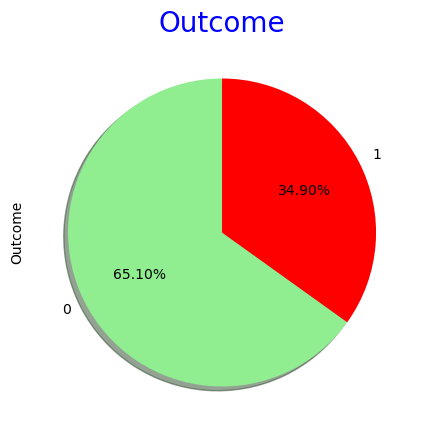

In [77]:
# 畫圖
colors = ["lightgreen", "red"]
rowdata["Outcome"].value_counts().plot(
    kind="pie", #圖形類別: 圓餅圖
    shadow=True, #圓餅圖要不要有陰影
    startangle=90,#設定圓餅圖角度
    figsize=(5, 5),#設定圖形的大小
    autopct="%1.2f%%",
    colors=colors,
)
plt.title("Outcome", fontsize=20, color="blue")

> 透過圖表的方式呈現Outcome的比例，我們發現有症狀的人比例只有34.9%，而沒有症狀的比例高達65.1%。

### 資料特徵分析

* 透過將數據繪製成圖表的方式，觀察資料的特徵，為後續的資料清整以及模型的開發進行探索。

In [78]:
#因為Outcome為標註資訊，其他欄位才是特徵變量，因此我們需要將除了Outcome的欄位取出來
num_cols = [col for col in rowdata.columns if rowdata[col].name != 'Outcome'] 
print(num_cols)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


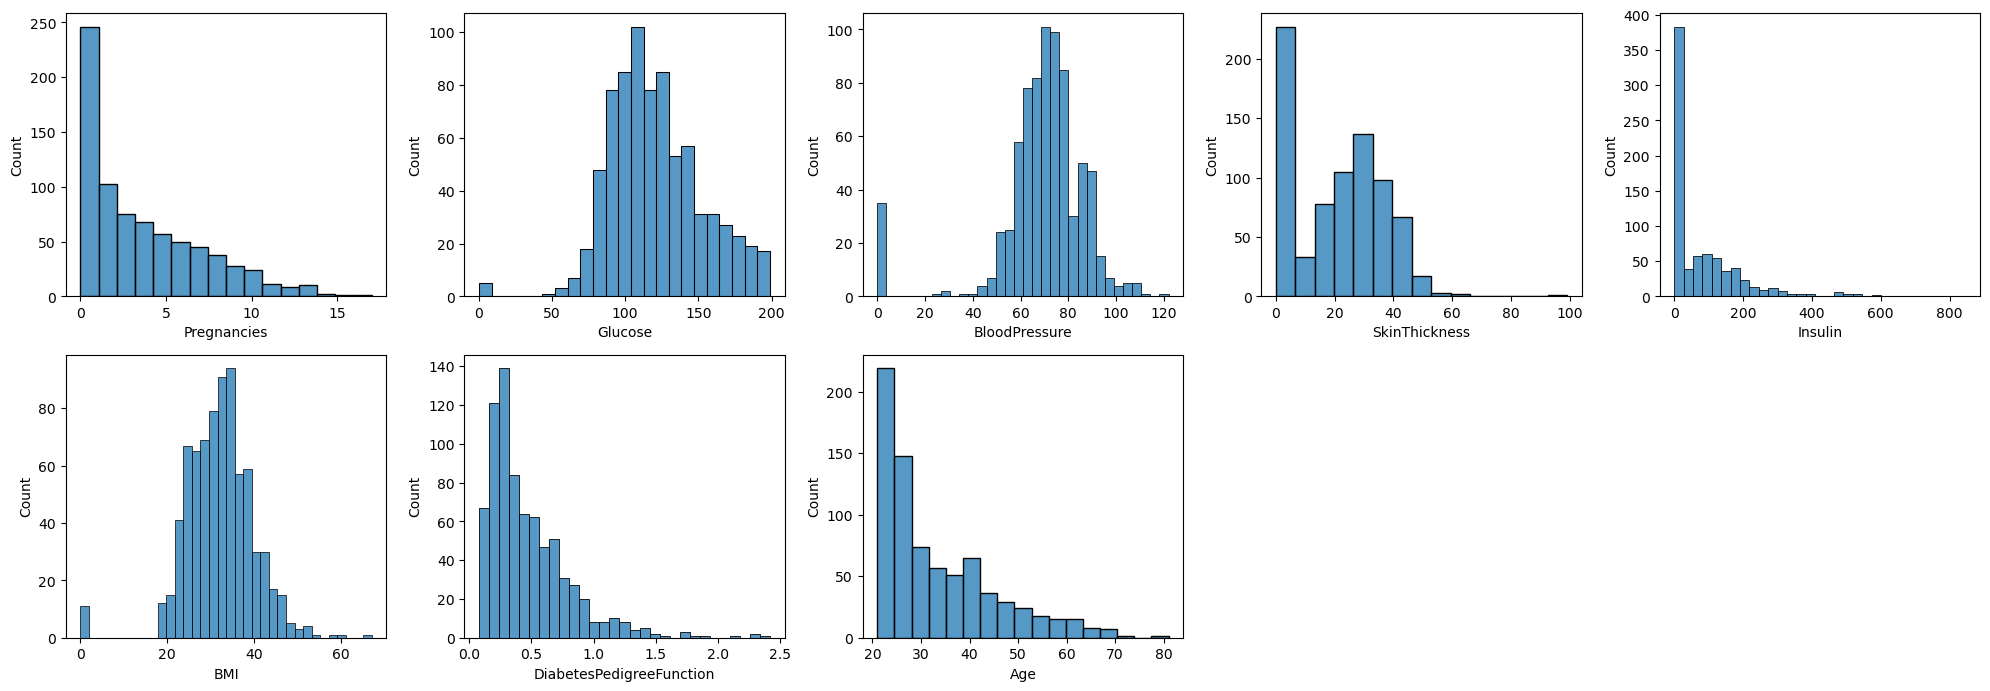

In [79]:
# 將每一個特徵變量繪製成長條圖，檢視資料的分布情況
plt.figure(figsize = (20,10))
plot_number = 1
for column in num_cols:
    if plot_number <= 14:
        ax = plt.subplot(3, 5, plot_number)
        sns.histplot(rowdata[column])
        plt.xlabel(column)
        
    plot_number += 1

plt.tight_layout()
plt.show()

> 從這邊的長條圖我們可以發現，此資料具有一些異常值，正常來說人體的Glucose(血液中葡萄糖濃度)、BloodPressure(血壓)、SkinThickness(皮褶厚度)、Insulin(胰島素濃度)以及BMI(BMI 值)不應該為0，因此在後續開發模型的時候，可能需要對這部分的資料進行處理。

### 資料探索

* 繪製提琴圖(violin)·觀察'BMI'與是否患病的高低關係
* 繪製分布估計圖(kde),觀察'隨機血糖'與是否患病的高低關係
* 繪製散佈圖(scatter)·觀察'BMI'與'隨機血糖'的高低關係

In [80]:
# 定義畫圖的function
def violin(col):
    fig = px.violin(rowdata, y=col, x="Outcome", color="Outcome", box=True, template = 'plotly_dark')
    return fig.show()
def kde(col):
    grid = sns.FacetGrid(rowdata, hue="Outcome", height = 6, aspect=2)
    grid.map(sns.kdeplot, col)
    grid.add_legend()
def scatter(col1, col2):
    fig = px.scatter(rowdata, x=col1, y=col2, color="Outcome", template = 'plotly_dark')
    return fig.show()

In [81]:
violin('BMI')

> 從這張提琴圖我們可以發現，患病的人大多數的BMI都落在30~40之間，但沒患病的人BMI也是落在25~35之間，由此可以發現BMI可能會影響是否患病，但並非一個很強烈的因素。

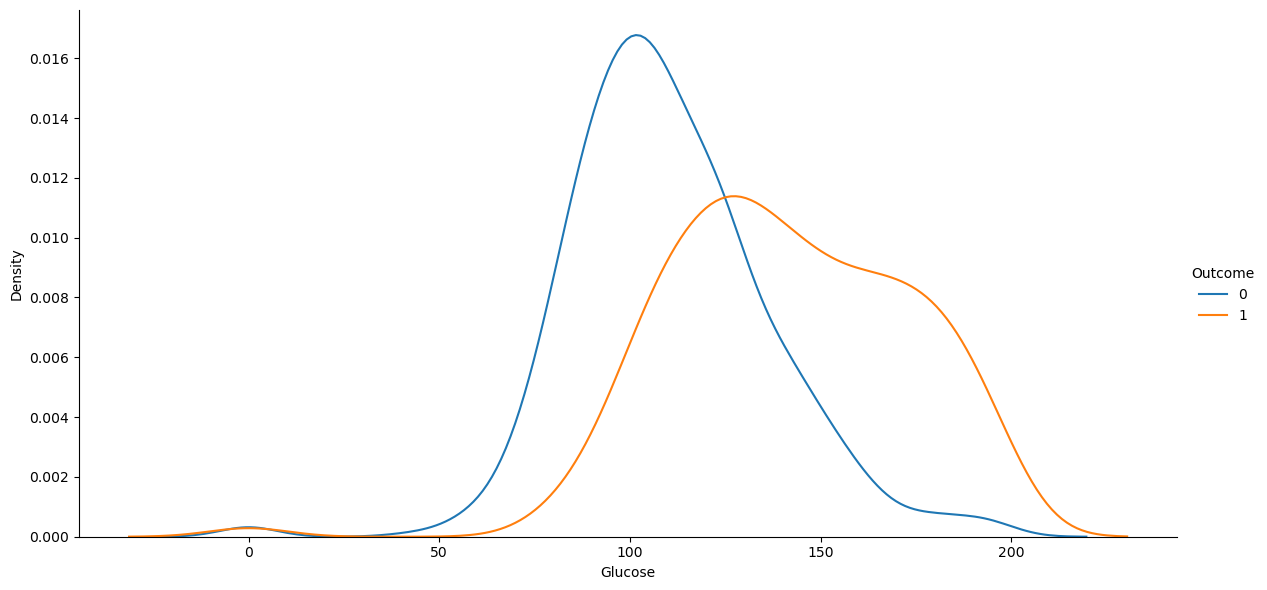

In [82]:
kde('Glucose')

> 從這張表我們可以發現，如果血液中的葡萄糖低，患病的比例也會比較低，反之如果是有症狀的人，大多數血液中的葡萄糖都大於100。

In [83]:
scatter('BMI', 'Glucose')

> 透過散佈圖來做進一步的分析，我們可以發現兩個結論:
 >> (1) 在BMI跟Glucose這兩個特徵裡面，都有存在異常值0，對於正常人來說，這兩個數值都不應該為0，因此後面在開發模型時需要進行資料清理。                     
 >> (2) 相對於BMI這個因素，患病與否受到Glucose的影響較大。

### 資料清理

* 檢查是否有重複值

In [84]:
# 將每筆資料除了outcome以外的欄位去做比對
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
rowdata_re = rowdata[rowdata.duplicated(subset=column_names, keep=False)]

# 如果有重複值就輸出重複的欄位
if(rowdata_re.empty):
    print("沒有重複值")
else:
    print(rowdata_re)

沒有重複值


> 檢查這份資料裡面是否包含重複的值，透過檢查每個欄位的內容是否有完全相同的數據，透過比對我們發現這份資料集沒有重複值。

* 缺失值檢查

In [85]:
#檢查缺失值數量
rowdata.isnull().sum(axis=0)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

> 結果發現並沒有存在空缺的資料，因此我們不需要做處理。

* 異常值處理

In [86]:
# 計算Glucose、BloodPressure、SkinThickness、Insulin以及BMI資料為0的筆數。
print("Glucose is 0 : ", rowdata[rowdata.Glucose == 0].shape[0])
print("BloodPressure is 0 : ", rowdata[rowdata.BloodPressure == 0].shape[0])
print("SkinThickness is 0 : ", rowdata[rowdata.SkinThickness == 0].shape[0])
print("Insulin is 0 : ", rowdata[rowdata.Insulin == 0].shape[0])
print("BMI is 0 : ", rowdata[rowdata.BMI == 0].shape[0])

Glucose is 0 :  5
BloodPressure is 0 :  35
SkinThickness is 0 :  227
Insulin is 0 :  374
BMI is 0 :  11


> 從結果我們可以發現，Glucose、BloodPressure以及BMI有異常值的資料筆數都相當低，直接移除對於模型開發不會有太大的影響。而SkinThickness以及Insulin有異常值的資料筆數占了整份資料相當大的一個比例，如果任意的移除會失去大量的有效資料，所以這邊我們不對SkinThickness以及Insulin做移除的動作。

In [87]:
# 移除BloodPressure、BMI或Glucose欄位中資料為0的資料
clear_rowdata = rowdata.loc[~((rowdata['BloodPressure'] == 0) | (rowdata['BMI'] == 0)|(rowdata['Glucose'] == 0))]
clear_rowdata.reset_index(inplace=True)
print(clear_rowdata)

     index  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0        0            6      148             72             35        0  33.6   
1        1            1       85             66             29        0  26.6   
2        2            8      183             64              0        0  23.3   
3        3            1       89             66             23       94  28.1   
4        4            0      137             40             35      168  43.1   
..     ...          ...      ...            ...            ...      ...   ...   
719    763           10      101             76             48      180  32.9   
720    764            2      122             70             27        0  36.8   
721    765            5      121             72             23      112  26.2   
722    766            1      126             60              0        0  30.1   
723    767            1       93             70             31        0  30.4   

     DiabetesPedigreeFuncti

## 模型開發步驟-使用LinearRegression開發模型

* 選擇特徵變量以及標註資訊

In [88]:
# 從清整完的資料中指定特徵變量以及標註資訊
x_features=clear_rowdata.iloc[:,:-1]
y_label = clear_rowdata.iloc[:,-1]

* 使用LinearRegression開發模型

In [89]:
# 指定LinearRegression作為模型
model = LinearRegression()

* K-fold交叉驗證

In [90]:
# 執行K-fold交叉驗證
test_bias = []
test_variance = []
train_errors = []
test_errors = []
kf = KFold(n_splits=6,shuffle=True,random_state=666)

for train_index,test_index in kf.split(x_features):

    # 拆分數據集為訓練集和測試集
    X_train,y_train=x_features.iloc[train_index],y_label[train_index]
    X_test,y_test=x_features.iloc[test_index],y_label[test_index]

    # 訓練模型
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train) # 預測訓練集資料
    y_test_pred = model.predict(X_test) # 預測測試集資料
    
    # 計算偏差Bias和變異性Variance
    bias = np.sum((y_test_pred - np.mean(y_test) **2) / len(y_test_pred))
    variance = np.sum((y_test_pred - np.mean(y_test_pred)) **2) / len(y_test_pred)
    
    test_bias.append(bias)
    test_variance.append(variance)

    # 計算訓練和測試的誤差
    train_error = np.sum((y_train_pred - y_train) ** 2) / len(y_train_pred)
    test_error = np.sum((y_test_pred - y_test) ** 2) / len(y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

#輸出bias and variance
print("Bias:",test_bias)
print("Variance:",test_variance)
#輸出平均訓練和測試誤差
print("平均訓練誤差:" , sum(train_errors) / len(train_errors))
print("平均測試誤差:" , sum(test_errors) / len(test_errors))

Bias: [0.24672368648875034, 0.21367866079321424, 0.2028899087089336, 0.19473826546582645, 0.2864623406934219, 0.21303788893273395]
Variance: [0.08306795950669817, 0.05327750287060839, 0.07877782902822701, 0.07972138475474627, 0.06445271309835146, 0.07925640847015147]
平均訓練誤差: 0.15303394489553263
平均測試誤差: 0.15963700606867162
